## dctcompression2.ipynb

In [1]:
datasetinfo = { "dataset":"su_african_crops_ghana",
                "groundcollection":"su_african_crops_ghana_labels",
                "s1collection":"su_african_crops_ghana_source_s1",
                "s2collection":"su_african_crops_ghana_source_s2",
                "datadir":"../data/",
                "metadatadir":"../data/metadata/",
                "extension":"tif"
              }
import sys
sys.path.insert(0,"../cropseg/")
from mlhubdata import loadjson
groundlabels = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundcollection"]}_id.json')
groundmetadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundcollection"]}.json')
s1metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s1collection"]}.json')
s2metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s2collection"]}.json')
s1bands = [
            {"band":"vv","idx":0},
            {"band":"vh","idx":1},    
          ]  
s2bands = [
            {"band":"blue","idx":0},
            {"band":"green","idx":1},
            {"band":"red","idx":2},
            {"band":"rded1","idx":3},
            {"band":"rded2","idx":4},
            {"band":"rded3","idx":5},
            {"band":"nir","idx":6},
            {"band":"rded4","idx":7},
            {"band":"swir1","idx":8},
            {"band":"swir2","idx":9}
          ]
s1idxs = ["vhvv"]
s2idxs = ["ndvi","gndvi","gci","rdedci","ndmi"]
erosioniterations = 2
dctcoefficients = 10
skiplist = ["001268","001271"]

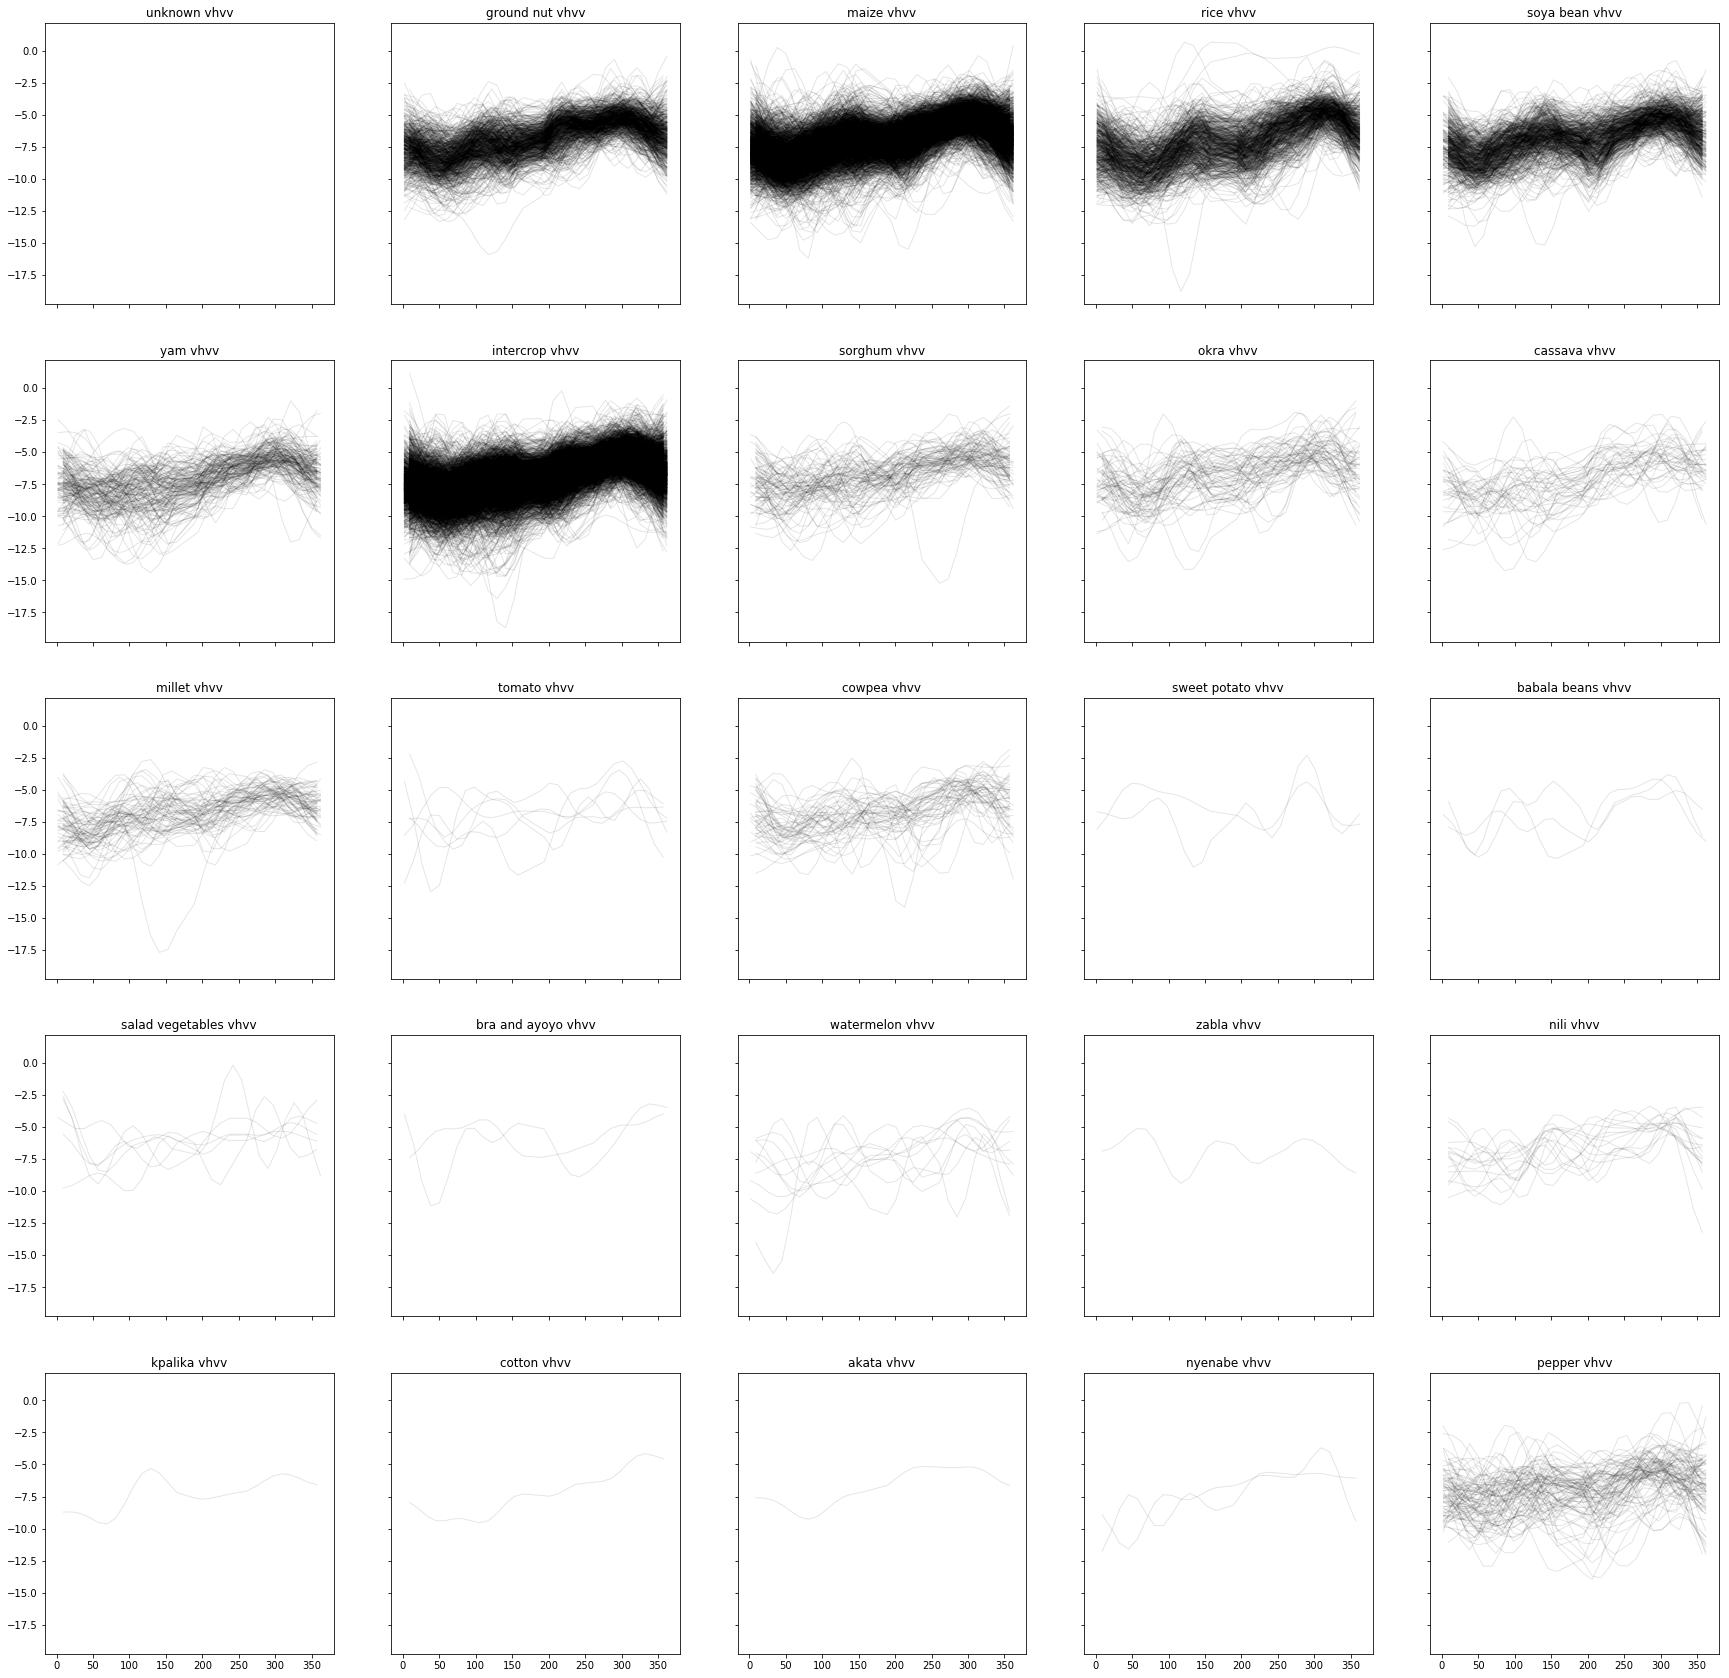

In [3]:
import numpy
import datetime
import scipy.fftpack
import matplotlib.pyplot
from osgeo import gdal
from satellitedata import getEOIndicies
from grounddata import getFieldMasks
from plotting import datepositions

s1idx = 0

fig,ax = matplotlib.pyplot.subplots(5,5,figsize=[30,30],sharex="all",sharey="all")
axs = ax.ravel()
for i in range(len(groundmetadata)):
    tileid = groundmetadata[i]["id"].split("_")[len(groundmetadata[i]["id"].split("_"))-1]
    if tileid not in skiplist:
        tile = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["groundcollection"]}/{groundmetadata[i]["id"]}/labels.{datasetinfo["extension"]}')
        tiledata = numpy.array(tile.GetRasterBand(1).ReadAsArray(),dtype='int')
        crops = numpy.unique(tiledata[tiledata != 0])
        fieldmasks = getFieldMasks(tiledata,erosioniterations)
        ###
        s1items = []
        for j in range(len(s1metadata)):
            if tileid in s1metadata[j]["id"]:
                s1items.append(s1metadata[j])
        s1items = sorted(s1items,key=lambda k:k["properties"]["datetime"])
        s1dates = []
        for j in range(len(s1items)):
            s1dates.append(datetime.datetime.strptime(s1items[j]["properties"]["datetime"],"%Y-%m-%dT%H:%M:%S+0000").date())   
        ###
        s1data = numpy.zeros([len(s1items),len(s1bands),numpy.shape(tiledata)[0],numpy.shape(tiledata)[1]])
        for j in range(len(s1items)):
            tile = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["s1collection"]}/{s1items[j]["id"]}/source.{datasetinfo["extension"]}')    
            for k in range(len(s1bands)):
                s1data[j][k] = tile.GetRasterBand(k+1).ReadAsArray()
        s1indices = getEOIndicies(s1data,s1bands,s1idxs)
        ###
        for j in range(len(fieldmasks)):
            for k in range(fieldmasks[j][1]):
                data = [[],[]]
                for n in range(len(s1indices)):
                    fm = numpy.copy(fieldmasks[j][0])
                    data[0].append(s1dates[n])
                    data[1].append(numpy.mean(s1indices[n][s1idx][fm == k+1]))
                if (data[0][len(data[0])-1] - data[0][0]).days > 335:
                    if numpy.isnan(numpy.sum(data[1])) == False and numpy.max(data[1]) != 0.0:
                        dpos = datepositions(data[0],yearstart=True)
                        dct = scipy.fftpack.dct(data[1],norm="ortho",type=2)
                        coefficients = numpy.zeros(len(dpos))
                        coefficients[:dctcoefficients] = 1
                        coefficients = dct * coefficients
                        idct = scipy.fftpack.idct(coefficients,norm="ortho",type=2)
                        axs[crops[j]].plot(dpos,idct,linewidth=1,color="black",alpha=0.1)
for i in range(len(groundlabels)):
    axs[i].set_title(f'{groundlabels[i]["crop"]} {s1idxs[s1idx]}')
matplotlib.pyplot.show()

../cropseg/satellitedata.py:20: RuntimeWarning: invalid value encountered in true_divide
  indicies[:,i] = (data[:,nir] - data[:,red]) / (data[:,nir] + data[:,red])
../cropseg/satellitedata.py:24: RuntimeWarning: invalid value encountered in true_divide
  indicies[:,i] = (data[:,nir] - data[:,green]) / (data[:,nir] + data[:,green])
../cropseg/satellitedata.py:28: RuntimeWarning: invalid value encountered in true_divide
  indicies[:,i] = (data[:,nir] / data[:,green]) - 1
../cropseg/satellitedata.py:32: RuntimeWarning: invalid value encountered in true_divide
  indicies[:,i] = (data[:,nir] / data[:,reded1]) - 1
../cropseg/satellitedata.py:36: RuntimeWarning: invalid value encountered in true_divide
  indicies[:,i] = (data[:,nir] - data[:,swir1]) / (data[:,nir] + data[:,swir1])
../cropseg/satellitedata.py:28: RuntimeWarning: divide by zero encountered in true_divide
  indicies[:,i] = (data[:,nir] / data[:,green]) - 1
../cropseg/satellitedata.py:32: RuntimeWarning: divide by zero encounter

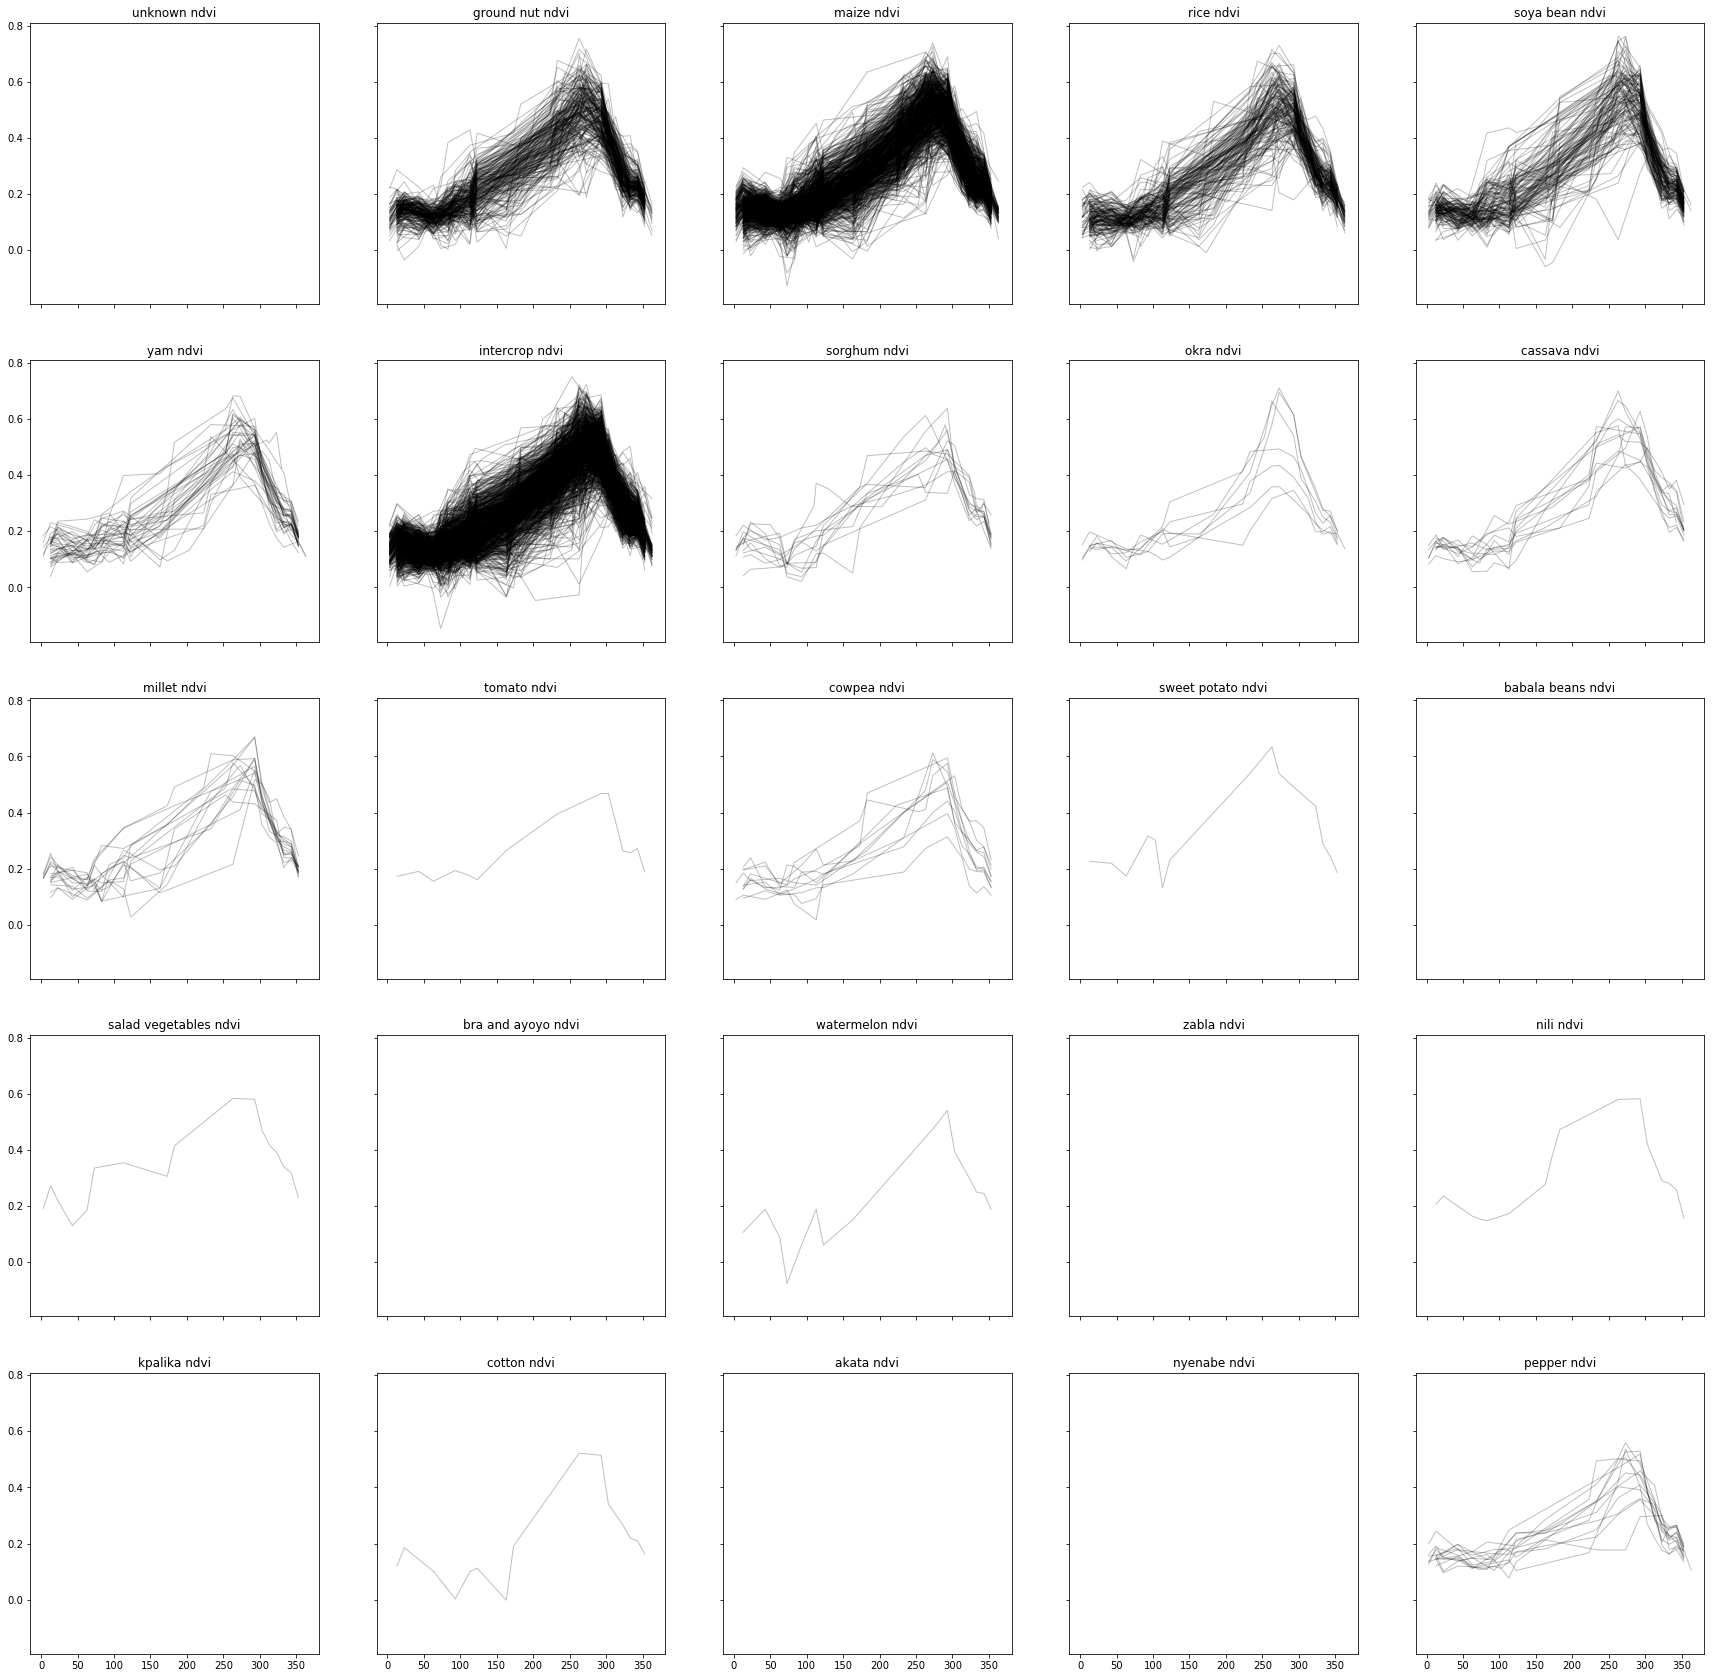

In [4]:
def plotS2VI(vi):
    fig,ax = matplotlib.pyplot.subplots(5,5,figsize=[30,30],sharex="all",sharey="all")
    axs = ax.ravel()
    for i in range(len(groundmetadata)):
        tileid = groundmetadata[i]["id"].split("_")[len(groundmetadata[i]["id"].split("_"))-1]
        if tileid not in skiplist:
            tile = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["groundcollection"]}/{groundmetadata[i]["id"]}/labels.{datasetinfo["extension"]}')
            tiledata = numpy.array(tile.GetRasterBand(1).ReadAsArray(),dtype='int')
            crops = numpy.unique(tiledata[tiledata != 0])
            fieldmasks = getFieldMasks(tiledata,erosioniterations)
            ###
            s2items = []
            for j in range(len(s2metadata)):
                if tileid in s2metadata[j]["id"]:
                    s2items.append(s2metadata[j])
            s2items = sorted(s2items,key=lambda k:k["properties"]["datetime"])
            s2dates = []
            for j in range(len(s2items)):
                s2dates.append(datetime.datetime.strptime(s2items[j]["properties"]["datetime"],"%Y-%m-%dT%H:%M:%S+0000").date())   
            ###
            s2data = numpy.zeros([len(s2items),len(s2bands),numpy.shape(tiledata)[0],numpy.shape(tiledata)[1]])
            s2cloudmasks = numpy.zeros([len(s2items),numpy.shape(tiledata)[0],numpy.shape(tiledata)[1]],dtype='int')        
            for j in range(len(s2items)):
                tile = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["s2collection"]}/{s2items[j]["id"]}/source.{datasetinfo["extension"]}')
                mask = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["s2collection"]}/{s2items[j]["id"]}/cloudmask.{datasetinfo["extension"]}')
                for k in range(len(s2bands)):
                    s2data[j][k] = tile.GetRasterBand(k+1).ReadAsArray()
                s2cloudmasks[j] = mask.GetRasterBand(1).ReadAsArray()
            s2indices = getEOIndicies(s2data,s2bands,s2idxs)
            ###
            for j in range(len(fieldmasks)):
                for k in range(fieldmasks[j][1]):
                    data = [[],[]]
                    for n in range(len(s2indices)):
                        fm = numpy.copy(fieldmasks[j][0])
                        fm[s2cloudmasks[n] != 0] = 0
                        if len(s2indices[n][vi][fm == k+1]) > 0:
                            data[0].append(s2dates[n])
                            data[1].append(numpy.mean(s2indices[n][vi][fm == k+1]))
                    if len(data[0]) > 14:
                        if (data[0][len(data[0])-1] - data[0][0]).days > 305:
                            if numpy.isnan(numpy.sum(data[1])) == False and numpy.max(data[1]) != 0.0:
                                dpos = datepositions(data[0],yearstart=True)
                                dct = scipy.fftpack.dct(data[1],norm="ortho",type=1)
                                coefficients = numpy.zeros(len(dpos))
                                coefficients[:dctcoefficients] = 1
                                coefficients = dct * coefficients
                                idct = scipy.fftpack.idct(coefficients,norm="ortho",type=1)
                                axs[crops[j]].plot(dpos,idct,linewidth=1,color="black",alpha=0.25)
    for i in range(len(groundlabels)):
        axs[i].set_title(f'{groundlabels[i]["crop"]} {s2idxs[vi]}')
    matplotlib.pyplot.show()
    
plotS2VI(0)

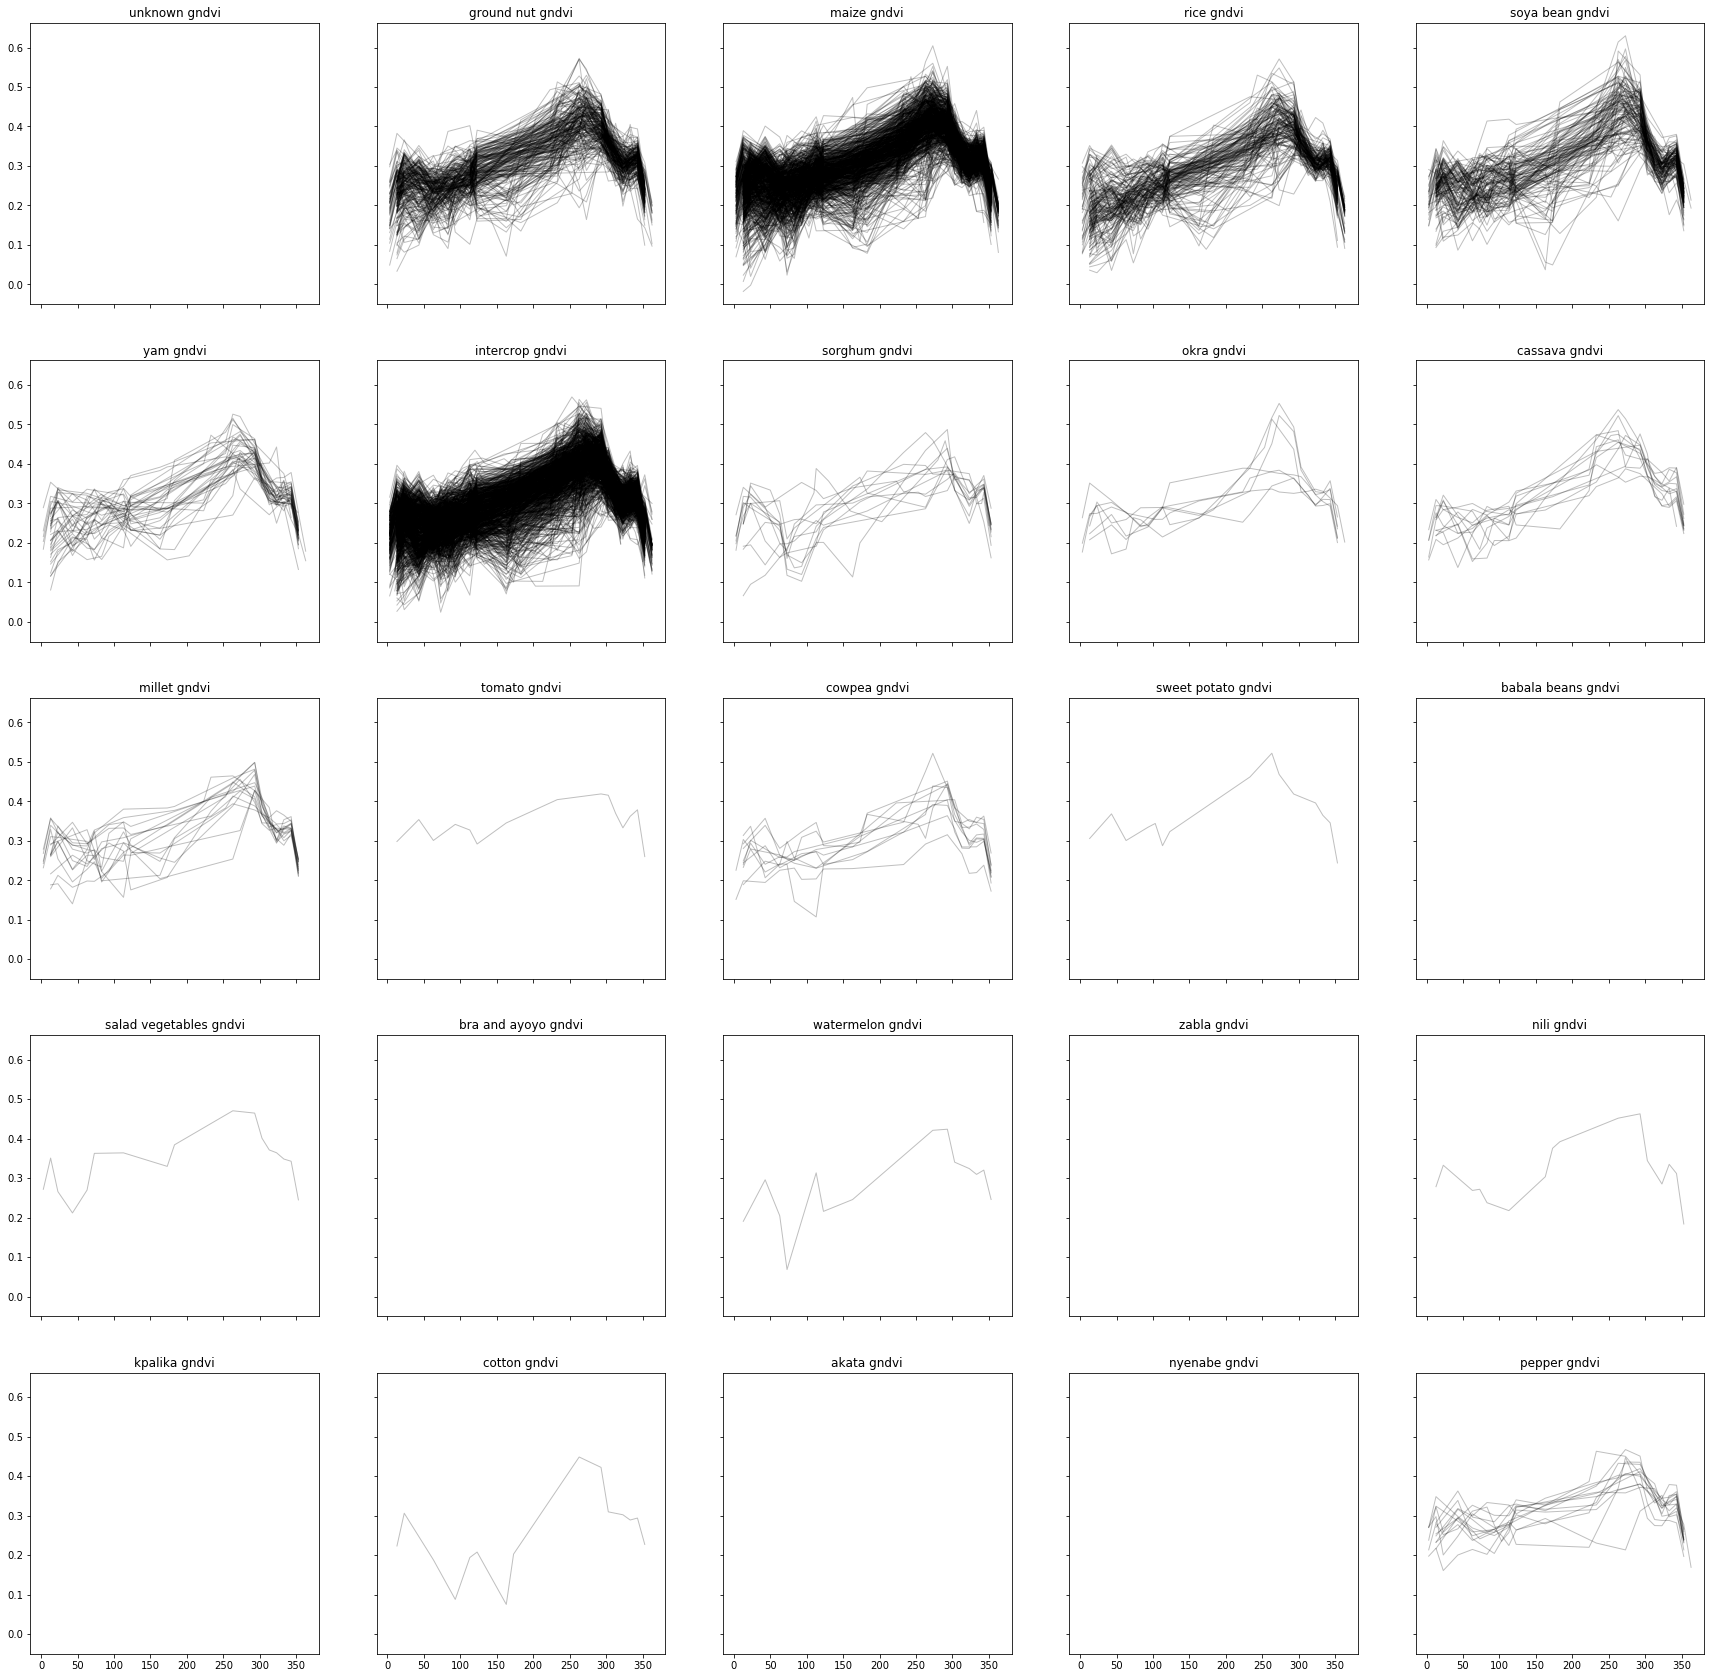

In [5]:
plotS2VI(1)

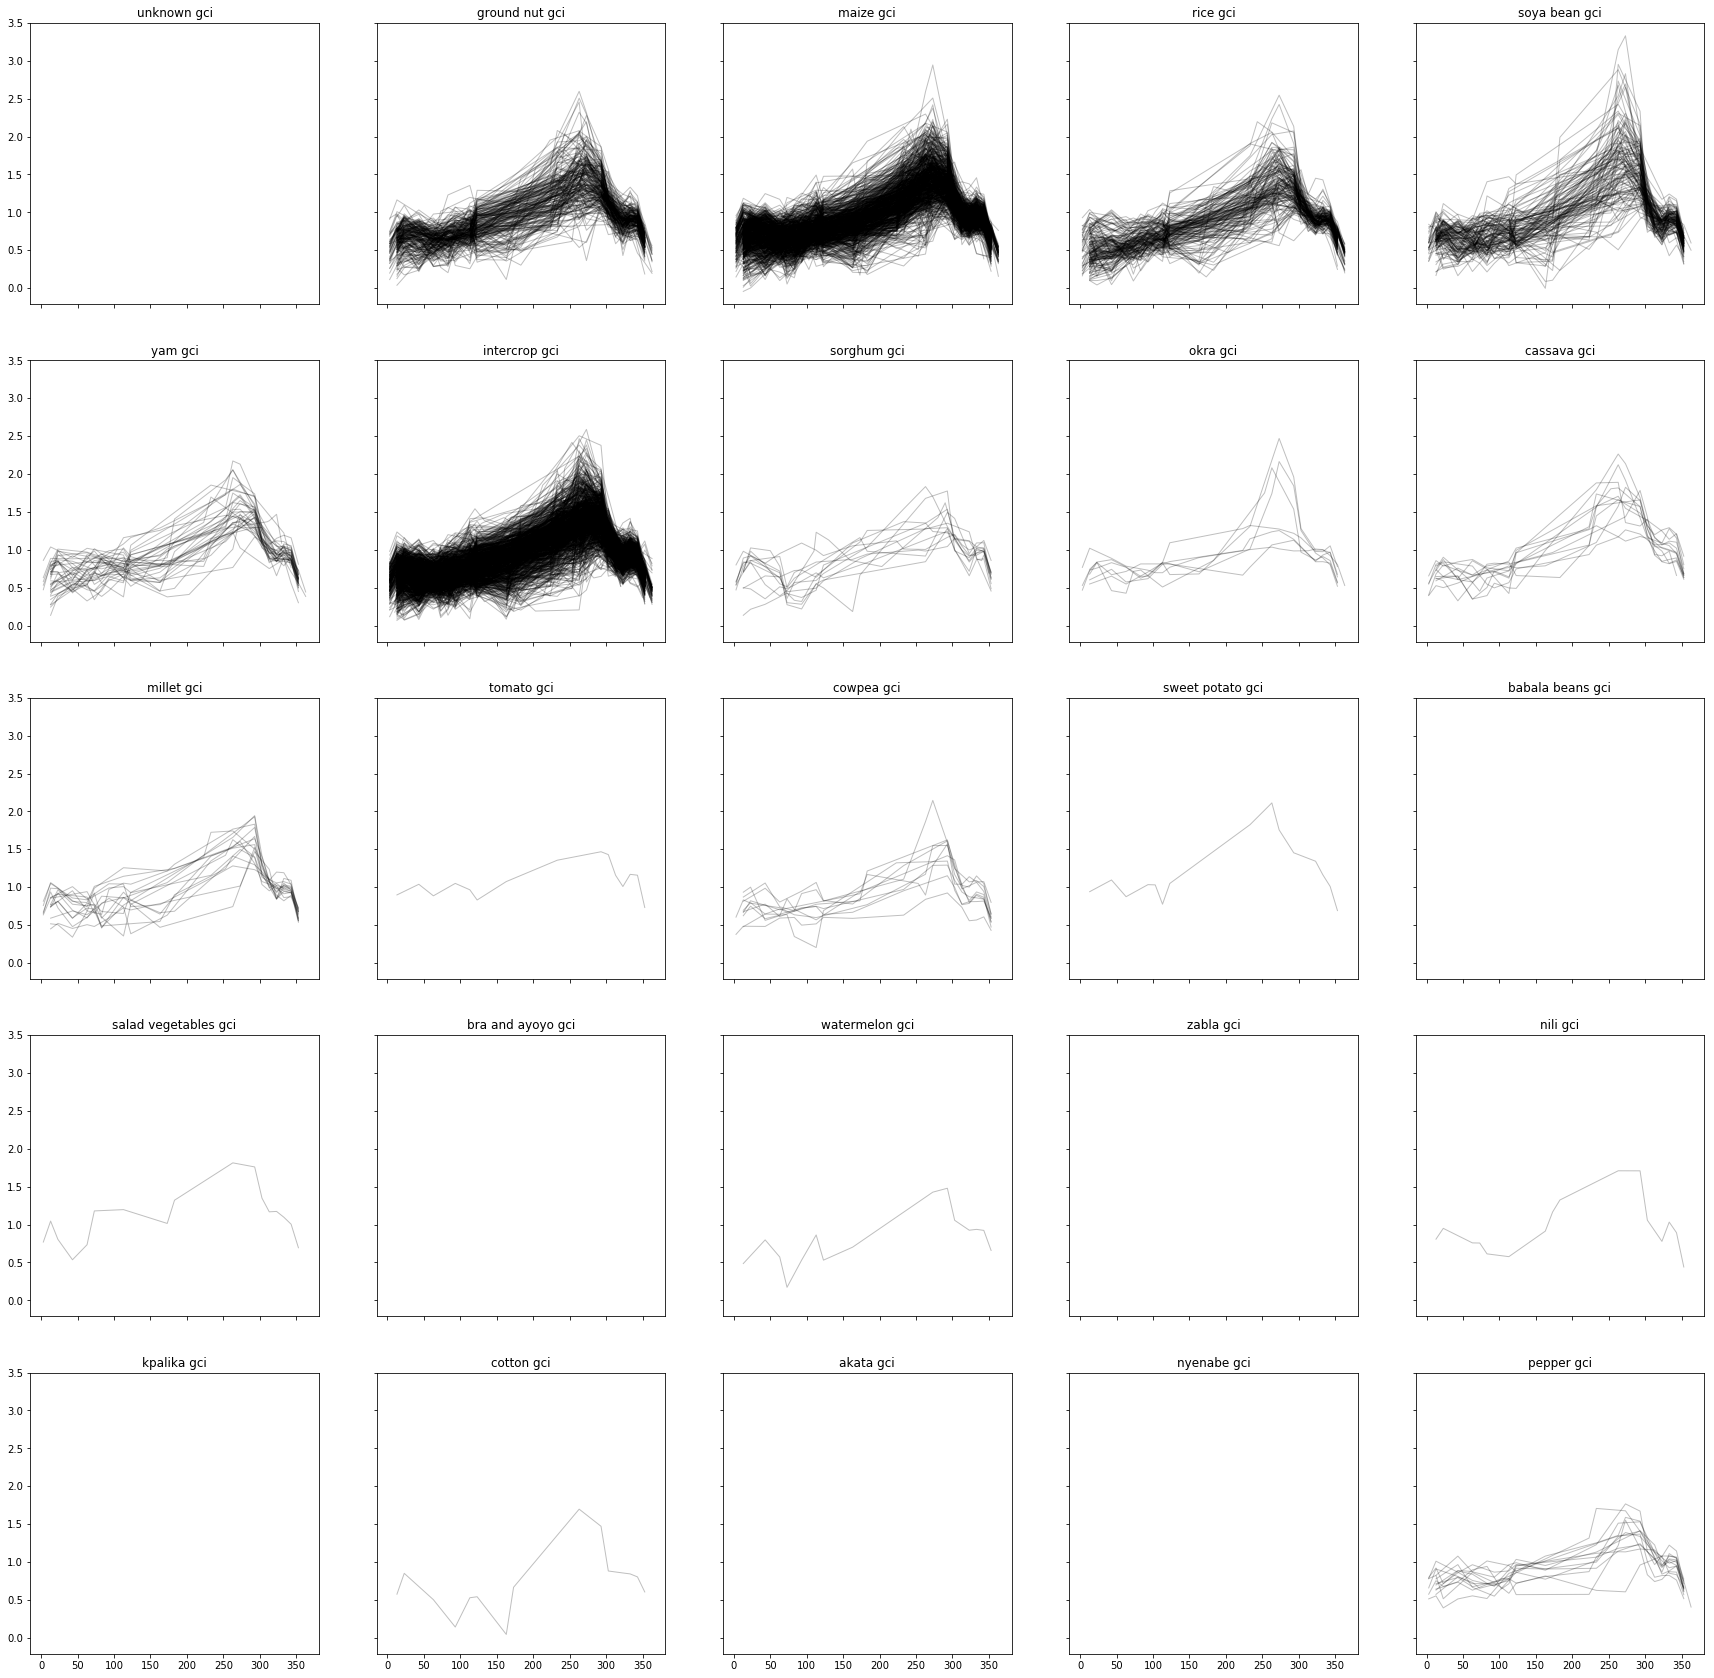

In [6]:
plotS2VI(2)

<ipython-input-4-50c018c3d966>:47: RuntimeWarning: invalid value encountered in multiply
  coefficients = dct * coefficients


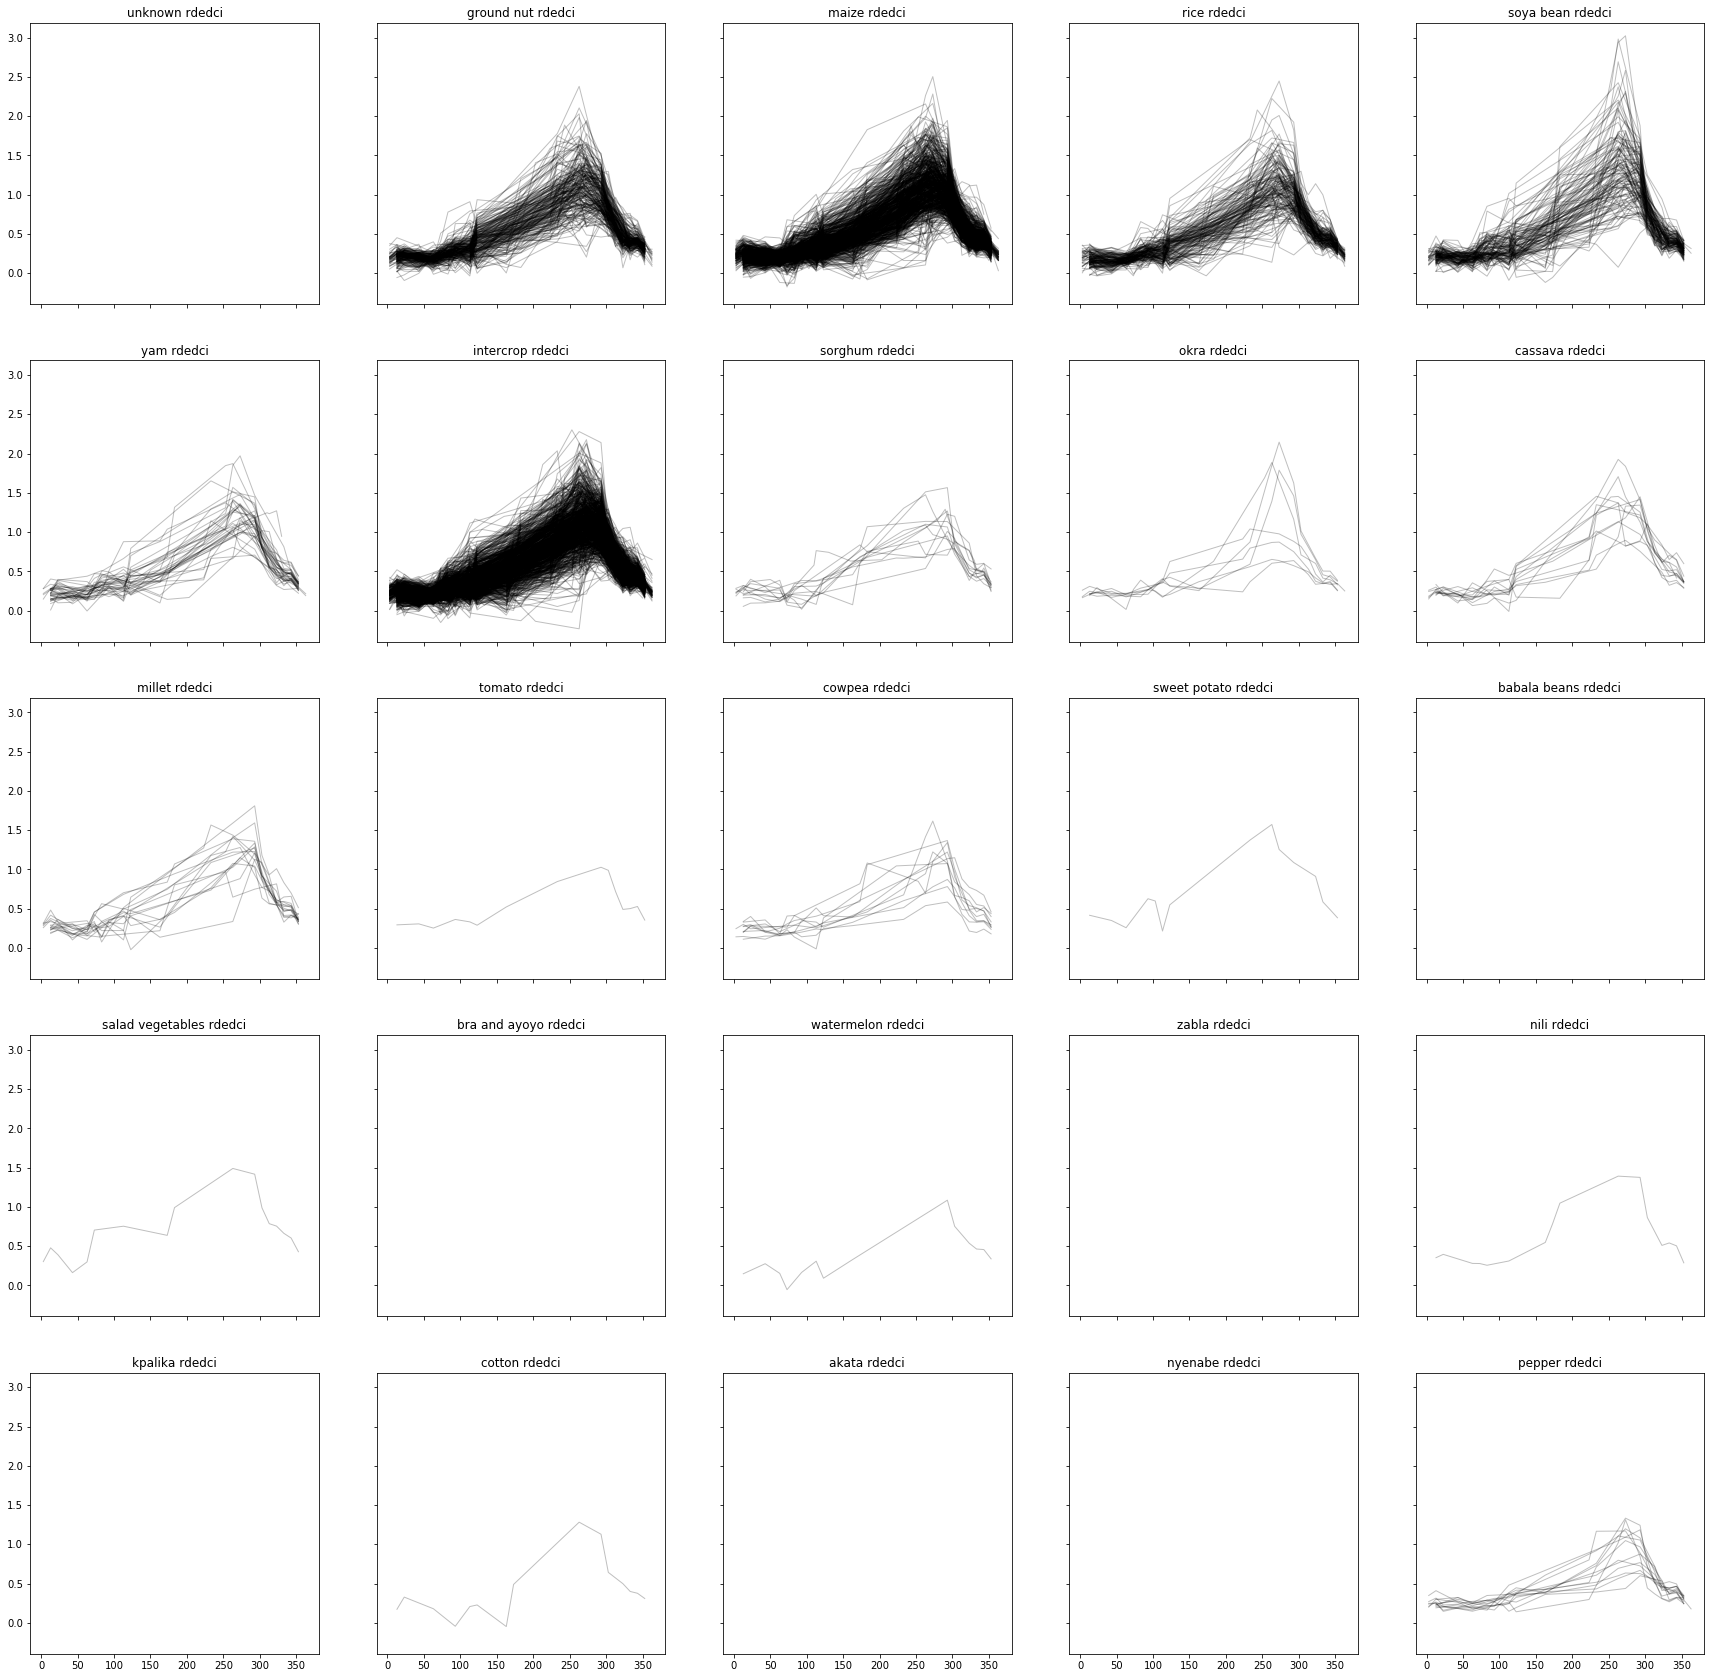

In [7]:
plotS2VI(3)

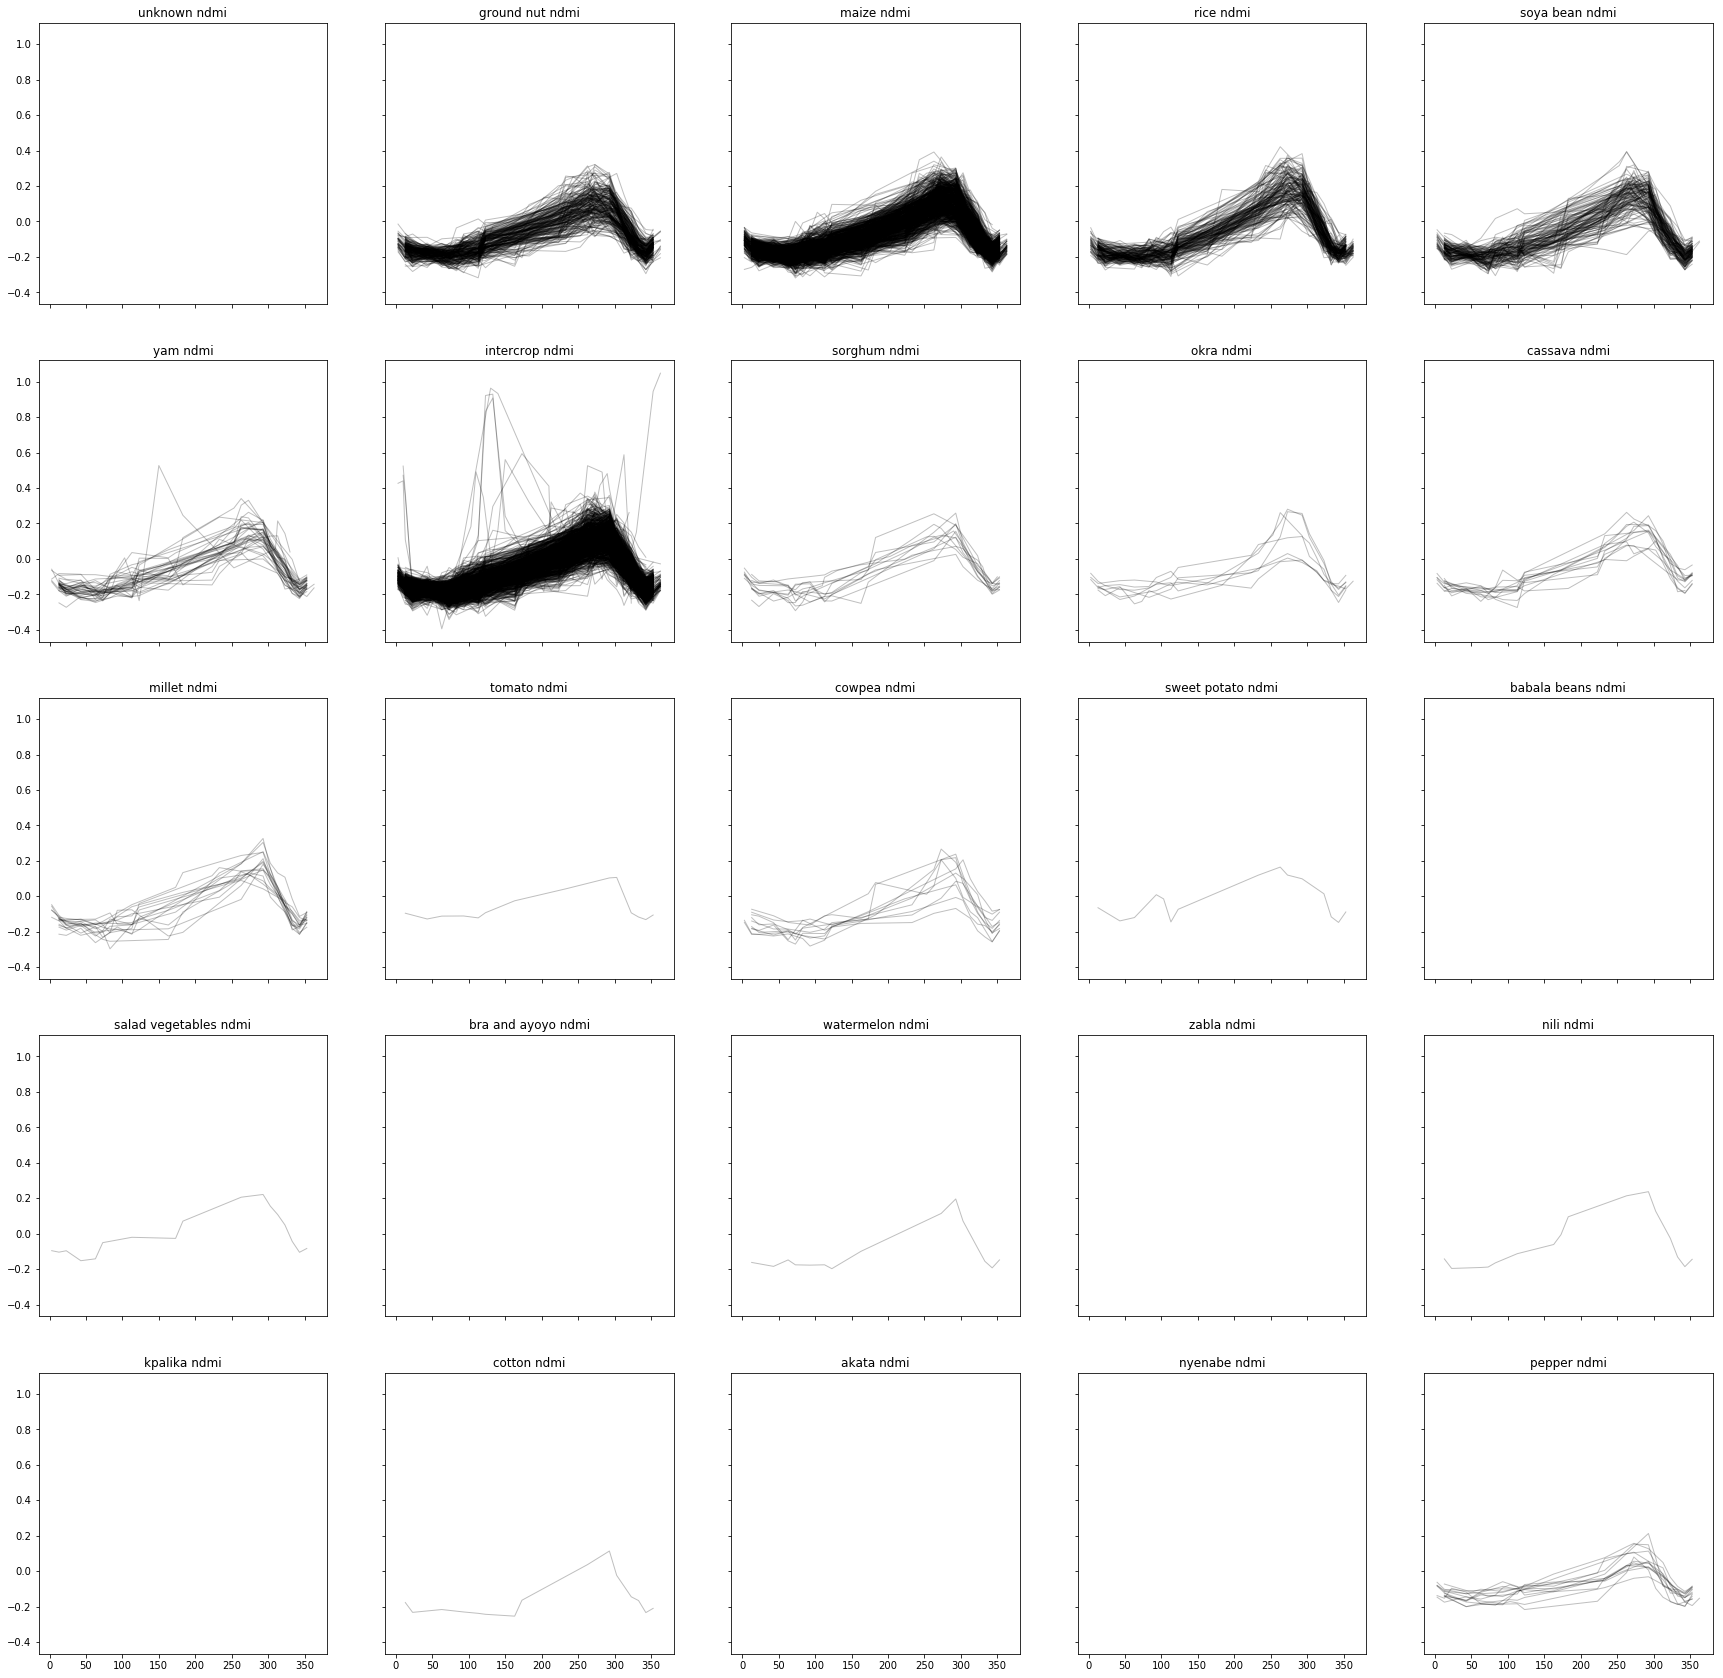

In [8]:
plotS2VI(4)